<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li><li><span><a href="#Финальные-комментарии-ревьюера" data-toc-modified-id="Финальные-комментарии-ревьюера-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Финальные комментарии ревьюера</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings("ignore")

сохраняем данные в переменную и смотрим общую информацию

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Проверим на дубликаты

In [4]:
df.duplicated().sum()

0

заполняем пропуски минимальными значениями

In [5]:
df['Tenure'] = df['Tenure'].fillna(0)

## Исследование задачи

Удалим столбцы-идентификаторы, не представляющие ценностия для алгоритма.
создадим дополнительный датафрем, в котором будут хранится данные для обучения модели

In [6]:
drop_columns = ['RowNumber','CustomerId', 'Surname']
df_ml = df.drop(drop_columns, axis=1)


In [7]:
df_ml.shape

(10000, 11)

Данные подготовим методом OHE, что позволит нам использовать разные модели и не словить дамми ловушку

In [ ]:
df_ml = pd.get_dummies(df_ml, drop_first=True)

In [8]:
df_ml.shape

(10000, 11)

Разделим на признаки и целевой признак

In [9]:
features = df_ml.drop('Exited', axis=1)
target = df_ml['Exited']

In [10]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                    target,
                                                    train_size=0.6,
                                                    random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                    target_test,
                                                    train_size=0.5,
                                                    random_state=12345)


посмотрим исходные валидационные данные, чтобы сравнить их с от маштабированными в дальнейшем

In [11]:
features_valid.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8532,585,France,Female,35,2.0,0.00,2,1,0,98621.04
5799,625,France,Female,45,3.0,0.00,1,1,1,184474.15
5511,667,Germany,Male,32,0.0,103846.65,1,1,0,20560.69
7365,568,Spain,Female,36,10.0,153610.61,1,1,1,54083.80
7367,606,Spain,Male,42,10.0,0.00,2,1,0,177938.52


In [12]:
features_valid.shape

(2000, 10)

посмотрим исходные тренировочные данные, чтобы сравнить их с от маштабированными в дальнейшем

In [13]:
features_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,567,Spain,Male,35,8.0,153137.74,1,1,0,88659.07
3411,711,France,Female,37,8.0,113899.92,1,0,0,80215.20
6027,850,Germany,Male,44,3.0,140393.65,2,0,1,186285.52
1247,512,France,Male,24,6.0,0.00,2,1,0,37654.31
3716,665,Germany,Female,27,2.0,147435.96,1,0,0,187508.06


In [14]:
features_train.shape

(6000, 10)

посмотрим исходные тестовые данные, чтобы сравнить их с от маштабированными в дальнейшем

In [15]:
features_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,567,Spain,Male,35,8.0,153137.74,1,1,0,88659.07
3411,711,France,Female,37,8.0,113899.92,1,0,0,80215.20
6027,850,Germany,Male,44,3.0,140393.65,2,0,1,186285.52
1247,512,France,Male,24,6.0,0.00,2,1,0,37654.31
3716,665,Germany,Female,27,2.0,147435.96,1,0,0,187508.06


In [16]:
features_test.shape

(2000, 10)

In [17]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(features_train)

OneHotEncoder(handle_unknown='ignore')

In [18]:
enc.transform(features_train)
enc.transform(features_test)
enc.transform(features_valid)
enc.transform(features_test)

<2000x10392 sparse matrix of type '<class 'numpy.float64'>'
	with 16744 stored elements in Compressed Sparse Row format>

Для масштабирования методом scaler зафиксируем численные признаки

In [19]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [20]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

Масштабируем численные признаки обучающей выборки

In [21]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,-0.886751,Spain,Male,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705
3411,0.608663,France,Female,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945
6027,2.052152,Germany,Male,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095
1247,-1.457915,France,Male,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061
3716,0.130961,Germany,Female,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268


Масштабируем численные признаки валидационной выборки 

In [22]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8532,-0.699824,France,Female,-0.373192,-0.825373,-1.233163,0.830152,1,0,-0.015173
5799,-0.284431,France,Female,0.575842,-0.503694,-1.233163,-0.891560,1,1,1.471724
5511,0.151731,Germany,Male,-0.657902,-1.468729,0.438711,-0.891560,1,0,-1.367107
7365,-0.876366,Spain,Female,-0.278288,1.748053,1.239884,-0.891560,1,1,-0.786517
7367,-0.481743,Spain,Male,0.291132,1.748053,-1.233163,0.830152,1,0,1.358533


Масштабируем численные признаки тестовой выборки 

In [23]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7041,-2.226392,France,Male,-0.088482,-0.825373,-1.233163,0.830152,1,0,0.647083
5709,-0.087120,France,Female,0.006422,1.426375,-1.233163,-0.891560,1,0,-1.658410
7117,-0.917905,Spain,Male,-0.752805,0.139662,0.722307,-0.891560,1,1,-1.369334
7775,-0.253277,Spain,Male,0.101325,1.748053,-1.233163,0.830152,1,0,0.075086
8735,0.785204,France,Male,-0.847708,1.748053,0.615625,-0.891560,0,1,-1.070919


строим диаграмму, которая наглядно покажет дисбаланс данных на тренировочной выборке

<AxesSubplot:ylabel='Frequency'>

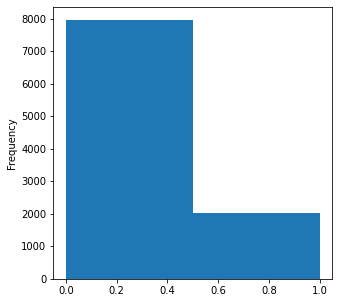

In [24]:
df_ml['Exited'].plot(kind ='hist', bins=2, figsize=(5,5))

строим диаграмму на тестовой выборке, чтобы убедиться в том, что дисбаланс есть и это не простая ошибка в тренировочной выборке.

Как мы выяснили в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%. С уверенностью можем сказать что дисбаланс присутствует и он существенный.

напишем функцию для изучия полноты, точности и F1-меры

In [25]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

обучаем модели

In [27]:
best_RF = None
best_accuracy_RF = 0
best_f1_RF=0
best_est_RF = 0
best_depth_RF = 0
for est in tqdm(range(10,200,10)):
    for depth in range(2,25):
        RF = RandomForestClassifier(random_state = 12345,n_estimators = est, max_depth = depth)
        RF.fit(features_train,target_train)
        prediction_valid_RF = RF.predict(features_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, target_valid)
        f1_RF = f1_score(prediction_valid_RF, target_valid)
        if best_f1_RF < f1_RF:
            best_f1_RF = f1_RF
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF

RF_probabilities_one_valid = best_RF.predict_proba(features_valid)[:, 1]

print(rec_prec_f1(target_valid,prediction_valid_RF))
print('AUC-ROC',roc_auc_score(target_valid, RF_probabilities_one_valid))
print()
print('лучшая модель с параметрами:', 'глубина-',best_depth_RF,'','количество ветвей-',best_est_RF)

100%|██████████| 19/19 [04:31<00:00, 14.30s/it]

Полнота 0.46411483253588515
Точность 0.754863813229572
F1-мера 0.5748148148148149
None
AUC-ROC 0.8383103273066013

лучшая модель с параметрами: глубина- 16  количество ветвей- 40


In [28]:
best_DT = None
best_accuracy_DT = 0
best_f1_DT = 0
best_depth_DT = 0
for depth in tqdm(range(2,52)):
    DT = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    DT.fit(features_train,target_train)
    prediction_valid_DT = DT.predict(features_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, target_valid)
    f1_DT = f1_score(prediction_valid_DT, target_valid)
    if best_f1_DT < f1_DT:
        best_f1_DT = f1_DT
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth
        
DT_probabilities_one_valid = best_DT.predict_proba(features_valid)[:, 1]

print(rec_prec_f1(target_valid,prediction_valid_DT))
print('AUC-ROC',roc_auc_score(target_valid, DT_probabilities_one_valid))
print()
print('лучшая модель с параметрами:', 'глубина-',best_depth_DT)

100%|██████████| 50/50 [00:01<00:00, 31.49it/s]

Полнота 0.47129186602870815
Точность 0.48883374689826303
F1-мера 0.47990255785627284
None
AUC-ROC 0.7899719632952051

лучшая модель с параметрами: глубина- 9


In [27]:
best_LR = None
best_f1_LR=0
best_accuracy_LR = 0
for iter_ in tqdm([100, 200, 500, 1000, 5000]):
    LR = LogisticRegression(random_state = 12345,max_iter=iter_,tol=1e-5,solver = 'lbfgs' )
    LR.fit(features_train,target_train)
    prediction_valid_LR = LR.predict(features_valid)
    accuracy_LR = accuracy_score(prediction_valid_LR, target_valid)
    f1_LR = f1_score(prediction_valid_LR, target_valid)
    if best_f1_LR < f1_LR:
        best_LR = LR
        best_accuracy_LR = accuracy_LR
            
LR_probabilities_one_valid = best_LR.predict_proba(features_valid)[:, 1]            
            
print(rec_prec_f1(target_valid,prediction_valid_LR))
print('AUC-ROC',roc_auc_score(target_valid, LR_probabilities_one_valid))

  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: could not convert string to float: 'Spain'

Вывод: Видим низкое значение F1, следовательно низкое качество моделей.

Функция для отображения соотношения ответов моделей (сколько 0, сколько 1)

In [30]:
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DT = DecisionTreeClassifier(random_state = 12345, max_depth = 9)
    model_DT.fit(features_train, target_train)
    DT_share = pd.Series(model_DT.predict(features_valid)).value_counts(normalize = 1)
    
    
    
    model_RF = RandomForestClassifier(random_state = 12345,n_estimators = 40, max_depth = 16)
    model_RF.fit(features_train, target_train)
    RF_share = pd.Series(model_RF.predict(features_valid)).value_counts(normalize = 1)
    
    model_LR = LogisticRegression(random_state = 12345,max_iter= 1000,tol=1e-5,solver = 'lbfgs')
    model_LR.fit(features_train, target_train)
    LR_share = pd.Series(model_LR.predict(features_valid)).value_counts(normalize = 1)
    

    
    print("Доли ответов:")
    print()
    print("Дерево решений", DT_share)
    print()
    print("Случайный лес ", RF_share)
    print()
    print("Логистческая регрессия", LR_share)

Применим функцию отображения соотношения ответов моделей

In [31]:
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:

Дерево решений 0    0.853
1    0.147
dtype: float64

Случайный лес  0    0.868
1    0.132
dtype: float64

Логистческая регрессия 0    0.9125
1    0.0875
dtype: float64


вывод: Логистичесая регрессия показала болюшую долю положительных ответов, далее случайный лес и в конце дерево решений
С учетом дисбаланса неудивительно, что модели с большой вероятностью будут выдавать ответ 0, построим матрицы ошибок для моделей

Матрица ошибок для дерево решений

In [32]:
confusion_matrix(target_valid, prediction_valid_DT)

array([[1376,  206],
       [ 221,  197]])

Матрица ошибок для случайный лес

In [33]:
confusion_matrix(target_valid, prediction_valid_RF)

array([[1519,   63],
       [ 224,  194]])

Вывод: Матрица показала, что дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP).

поработаем с логистической регрессией отдельно

In [34]:
confusion_matrix(target_valid, prediction_valid_LR)

array([[1506,   76],
       [ 319,   99]])

In [35]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

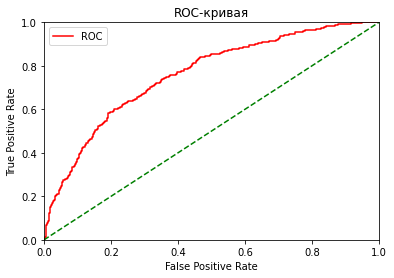

In [36]:
fper, tper, thresholds = roc_curve(target_valid, LR_probabilities_one_valid)
plot_roc_curve(fper, tper)

Попробуем обучать логистическую регресию сбалансировав классы

Score 0.8025
AUC-ROC 0.7587361404315294


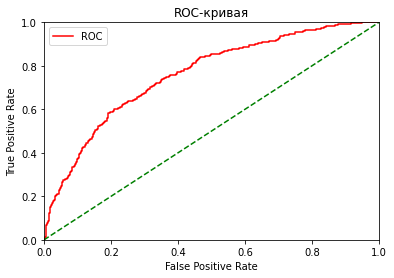

In [37]:
model_LR = LogisticRegression(random_state = 12345,max_iter= 1000,tol=1e-5,solver = 'lbfgs')
model_LR.fit(features_train, target_train)
LR_probabilities_one_valid_class_weight = model_LR.predict_proba(features_valid)[:, 1]
print("Score", model_LR.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, LR_probabilities_one_valid_class_weight))

fper, tper, thresholds = roc_curve(target_valid, LR_probabilities_one_valid_class_weight) 
plot_roc_curve(fper, tper)

Вывод: Отстутсвие улучшений - тоже результат. Высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.

## Борьба с дисбалансом

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%. Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса. Либо же уменьшить кол-во отрицтаельных ответов.

Создадим функцию для увеличения представленной класса в выборке 

In [38]:
def upsample(features, target, repeat, upsampled_сlass):
    """Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float),
    класс который будет увеличен (upsampled_сlass (0 or 1))"""
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled

Создадим функцию для уменьшения представленной класса в выборке 

In [39]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Применим функцию upsample.
увеличим количество положительных ответов в 4 раза.
Протестируем функцию.

In [40]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.501043
1    0.498957
Name: Exited, dtype: float64
(9588,)


Применим функцию upsample 
увеличим количество положительных ответов в 4 раза

In [41]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.501043
1    0.498957
Name: Exited, dtype: float64
(9588,)


Применим функцию downsample.
Уменьшим кол-в пооложительных ответов в 4 раза.
Протестируем функцию.

In [42]:
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.25)
print(target_downsampled_train.value_counts(normalize = 1))
print(target_downsampled_train.shape)

0    0.501043
1    0.498957
Name: Exited, dtype: float64
(2397,)


<AxesSubplot:ylabel='Frequency'>

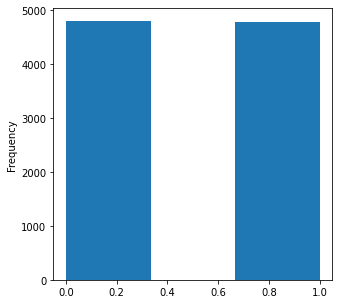

In [43]:
target_train_upsampled.plot(kind ='hist', bins=3, figsize=(5,5))

<AxesSubplot:ylabel='Frequency'>

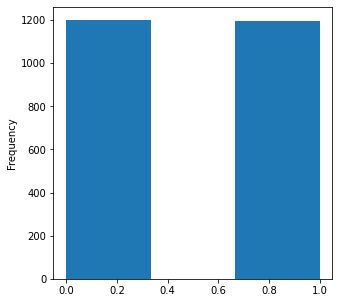

In [44]:
target_downsampled_train.plot(kind ='hist', bins=3, figsize=(5,5))

вывод:видим,что функции выдали одинаковый результат. Есть смысл проверить обе

проверим функцию 'upsampled'

Решающее дерево

In [45]:
best_DT_upsampled = None
best_accuracy_DT_upsampled = 0
best_f1_DT_upsampled=0
best_depth_DT_upsampled = 0
for depth in tqdm(range(2,52)):
    DT_upsampled = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    DT_upsampled.fit(features_train_upsampled, target_train_upsampled)
    prediction_valid_DT_upsampled = DT_upsampled.predict(features_valid)
    accuracy_DT_upsampled = accuracy_score(prediction_valid_DT_upsampled, target_valid)
    f1_DT_upsampled = f1_score(prediction_valid_DT_upsampled, target_valid)
    if best_f1_DT_upsampled < f1_DT_upsampled:
        best_f1_DT_upsampled = f1_DT_upsampled
        best_DT_upsampled = DT_upsampled
        best_accuracy_DT_upsampled = accuracy_DT_upsampled
        best_depth_DT_upsampled = depth
        
DT_upsampled_probabilities_one_valid = best_DT_upsampled.predict_proba(features_valid)[:, 1]

print(rec_prec_f1(target_valid,prediction_valid_DT_upsampled))
print('AUC-ROC',roc_auc_score(target_valid, DT_upsampled_probabilities_one_valid))
print()
print('лучшая модель с параметрами:', 'глубина-',best_depth_DT_upsampled)

100%|██████████| 50/50 [00:01<00:00, 26.03it/s]


Полнота 0.4449760765550239
Точность 0.4708860759493671
F1-мера 0.4575645756457565
None
AUC-ROC 0.8310244134068074

лучшая модель с параметрами: глубина- 5


Случайный лес

In [46]:
best_RF_upsampled = None
best_accuracy_RF_upsampled = 0
best_f1_RF_upsampled = 0
best_est_RF_upsampled = 0
best_depth_RF_upsampled = 0
for est in tqdm(range(10,200,10)):
    for depth in range(2,25):
        RF_upsampled = RandomForestClassifier(random_state = 12345,n_estimators = est, max_depth = depth)
        RF_upsampled.fit(features_train_upsampled, target_train_upsampled)
        prediction_valid_RF_upsampled = RF_upsampled.predict(features_valid)
        accuracy_RF_upsampled = accuracy_score(prediction_valid_RF_upsampled, target_valid)
        f1_RF_upsampled = f1_score(prediction_valid_RF_upsampled, target_valid)
        if best_f1_RF_upsampled < f1_RF_upsampled:
            best_f1_RF_upsampled = f1_RF_upsampled
            best_RF_upsampled = RF_upsampled
            best_depth_RF_upsampled = depth
            best_est_RF_upsampled = est
            best_accuracy_RF_upsampled = accuracy_RF_upsampled
            

RF_upsampled_probabilities_one_valid = best_RF_upsampled.predict_proba(features_valid)[:, 1]

print(rec_prec_f1(target_valid,prediction_valid_RF_upsampled))
print('AUC-ROC',roc_auc_score(target_valid, RF_upsampled_probabilities_one_valid))
print()
print('лучшая модель с параметрами:', 'глубина-',best_depth_RF_upsampled,'','количество ветвей-',best_est_RF_upsampled)

100%|██████████| 19/19 [06:09<00:00, 19.46s/it]

Полнота 0.5550239234449761
Точность 0.6823529411764706
F1-мера 0.612137203166227
None
AUC-ROC 0.84782148452386

лучшая модель с параметрами: глубина- 13  количество ветвей- 150


Логистическая регрессия

In [47]:
best_LR_upsampled = None
best_f1_LR_upsampled=0
best_accuracy_LR_upsampled = 0
for est in tqdm(range(2,52)):
    LR_upsampled = LogisticRegression(random_state = 12345,max_iter= 1000,tol=1e-5,solver = 'liblinear' )
    LR_upsampled.fit(features_train_upsampled, target_train_upsampled)
    LR_prediction_upsampled = LR_upsampled.predict(features_valid)
    accuracy_LR_upsampled = accuracy_score(LR_prediction_upsampled, target_valid)
    f1_LR_upsampled = f1_score(LR_prediction_upsampled, target_valid)
    if best_f1_LR_upsampled < f1_LR_upsampled:
        best_f1_LR_upsampled = f1_LR_upsampled
        best_LR_upsampled = LR_upsampled
        best_accuracy_LR_upsampled = accuracy_LR_upsampled
            
LR_upsampled_probabilities_one_valid = best_LR_upsampled.predict_proba(features_valid)[:, 1]            
            
print(rec_prec_f1(target_valid, LR_prediction_upsampled))
print('AUC-ROC',roc_auc_score(target_valid, LR_upsampled_probabilities_one_valid))

100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Полнота 0.6842105263157895
Точность 0.3803191489361702
F1-мера 0.4888888888888888
None
AUC-ROC 0.7634769748183815


проверим метод 'downsample'

Решающее дерево

In [48]:
best_DT_downsampled = None
best_accuracy_DT_downsampled = 0
best_f1_DT_downsampled=0
best_depth_DT_downsampled = 0
for depth in tqdm(range(2,52)):
    DT_downsampled = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    DT_downsampled.fit(features_downsampled_train, target_downsampled_train)
    prediction_valid_DT_downsampled = DT_downsampled.predict(features_valid)
    accuracy_DT_downsampled = accuracy_score(prediction_valid_DT_downsampled, target_valid)
    f1_DT_downsampled= f1_score(prediction_valid_DT_downsampled, target_valid)
    if best_f1_DT_downsampled < f1_DT_downsampled:
        best_f1_DT_downsampled = f1_DT_downsampled
        best_DT_downsampled = DT_downsampled
        best_accuracy_DT_downsampled = accuracy_DT_downsampled
        best_depth_DT_downsampled = depth
        
DT_downsampled_probabilities_one_valid = best_DT_downsampled.predict_proba(features_valid)[:, 1]

print(rec_prec_f1(target_valid,prediction_valid_DT_downsampled))
print('AUC-ROC',roc_auc_score(target_valid, DT_downsampled_probabilities_one_valid))
print()
print('лучшая модель с параметрами:', 'глубина-',best_depth_DT_downsampled)

100%|██████████| 50/50 [00:00<00:00, 50.24it/s]

Полнота 0.6913875598086124
Точность 0.3772845953002611
F1-мера 0.48817567567567566
None
AUC-ROC 0.82291433531536

лучшая модель с параметрами: глубина- 5


Случайный лес

In [49]:
best_RF_downsampled = None
best_accuracy_RF_downsampled = 0
best_f1_RF_downsampled=0
best_est_RF_downsampled = 0
best_depth_RF_downsampled = 0
for est in tqdm(range(10,200,10)):
    for depth in range(2,25):
        RF_downsampled = RandomForestClassifier(random_state = 12345,n_estimators = est, max_depth = depth)
        RF_downsampled.fit(features_downsampled_train, target_downsampled_train)
        prediction_valid_RF_downsampled = RF_downsampled.predict(features_valid)
        accuracy_RF_downsampled = accuracy_score(prediction_valid_RF_downsampled, target_valid)
        f1_RF_downsampled = f1_score(prediction_valid_RF_downsampled, target_valid)
        if best_f1_RF_downsampled < f1_RF_downsampled:
            best_f1_RF_downsampled = f1_RF_downsampled
            best_RF_downsampled = RF_downsampled
            best_depth_RF_downsampled = depth
            best_est_RF_downsampled = est
            best_accuracy_RF_downsampled = accuracy_RF_downsampled
            

RF_downsampled_probabilities_one_valid = best_RF_downsampled.predict_proba(features_valid)[:, 1]

print(rec_prec_f1(target_valid,prediction_valid_RF_downsampled))
print('AUC-ROC',roc_auc_score(target_valid, RF_downsampled_probabilities_one_valid))
print()
print('лучшая модель с параметрами:', 'глубина-',best_depth_RF_downsampled,'','количество ветвей-',best_est_RF_downsampled)

100%|██████████| 19/19 [02:31<00:00,  7.95s/it]

Полнота 0.7368421052631579
Точность 0.4797507788161994
F1-мера 0.5811320754716982
None
AUC-ROC 0.835229163012116

лучшая модель с параметрами: глубина- 4  количество ветвей- 10


Логистическая регрессия

In [50]:
best_LR_downsampled = None
best_f1_LR_downsampled=0
best_accuracy_LR_downsampled = 0
for est in tqdm(range(2,52)):
    LR_downsampled = LogisticRegression(random_state = 12345,max_iter= 1000,tol=1e-5,solver = 'liblinear' )
    LR_downsampled.fit(features_downsampled_train, target_downsampled_train)
    LR_prediction_downsampled = LR_downsampled.predict(features_valid)
    accuracy_LR_downsampled = accuracy_score(LR_prediction_downsampled, target_valid)
    f1_LR_downsampled = f1_score(LR_prediction_downsampled, target_valid)
    if best_f1_LR_downsampled < f1_LR_downsampled:
        best_f1_LR_downsampled = f1_LR_downsampled
        best_LR_downsampled = LR_downsampled
        best_accuracy_LR_downsampled = accuracy_LR_downsampled
            
LR_downsampled_probabilities_one_valid = best_LR_downsampled.predict_proba(features_valid)[:, 1]            
            
print(rec_prec_f1(target_valid, LR_prediction_downsampled))
print('AUC-ROC',roc_auc_score(target_valid, LR_downsampled_probabilities_one_valid))

100%|██████████| 50/50 [00:06<00:00,  8.17it/s]

Полнота 0.6818181818181818
Точность 0.3815261044176707
F1-мера 0.4892703862660944
None
AUC-ROC 0.7626709573612228


проверим Точность моделей на выборке с дисбалансом

In [51]:
print(best_accuracy_RF)
print(best_accuracy_DT)
print(best_accuracy_LR)

0.863
0.85
0.8025


проверим Точность моделей на сбалансированной увеличенной выборке

In [52]:
print(best_accuracy_RF_upsampled)
print(best_accuracy_DT_upsampled)
print(best_accuracy_LR_upsampled)

0.849
0.8105
0.701


проверим Точность моделей на сбалансированной уменьшенной выборке

In [53]:
print(best_accuracy_RF_downsampled)
print(best_accuracy_DT_downsampled)
print(best_accuracy_LR_downsampled)

0.803
0.799
0.7025


Вывод:Показаели всех моделей  обученных на сбалонсированных выборках ухудшились.Для 'upsampled' не сильно значительно, а вот для 'downsampled' ухудшения оказались более значительными.Поэтому я буду использовать метод 'upsampled' далее по проекту.

Лучшие результаты показывает модель 'RandomForest' обученная на данных сбалансированых методом 'upsampled'. На валидационной выборке 'RandomForest' уже показывает резульаты F1 меры = 0.60, что удовлетваряет условию данного проекта.

## Тестирование модели

Обучим финальную модель с обьединенными данными

In [54]:
features_full_train = pd.concat([features_train, features_valid])
target_full_train = pd.concat([target_train, target_valid])

In [55]:
features_upsampled, target_upsampled = upsample(features_full_train, target_full_train, 4, 1)

In [61]:
RF_final_full_data = RandomForestClassifier(random_state = 12345,n_estimators = 150, max_depth = 13)
RF_final_full_data.fit(features_upsampled, target_upsampled)

prediction_valid_RF_final_full_data = RF_final_full_data.predict(features_test)

f1_RF_final_full_data= f1_score(prediction_valid_RF_final_full_data, target_test)

RF_full_data_probabilities_one_valid = RF_final_full_data.predict_proba(features_test)[:, 1]

print(rec_prec_f1(target_test,prediction_valid_RF_final_full_data))
print('AUC-ROC',roc_auc_score(target_test, RF_full_data_probabilities_one_valid))


Полнота 0.6193853427895981
Точность 0.6121495327102804
F1-мера 0.6157461809635723
None
AUC-ROC 0.8569102839128069


Обучим финальную модель без обьединенных данных

In [57]:
RF_final = RandomForestClassifier( max_depth= 12,  n_estimators = 20, random_state=12345)
RF_final.fit(features_train_upsampled, target_train_upsampled)

RF_final_prediction =RF_final.predict(features_test)

RF_final_valid = RF_final.predict_proba(features_test)[:, 1]

auc_roc_RF = roc_auc_score(target_test, RF_final_valid)

print(rec_prec_f1(target_test, RF_final_prediction))
print('AUC-ROC',roc_auc_score(target_test, RF_final_valid))

Полнота 0.6170212765957447
Точность 0.6141176470588235
F1-мера 0.6155660377358491
None
AUC-ROC 0.8495744830760144


вывод: модель обученная на обьедененных данных оказалась менее точной (даже после маштобирования данных) по F-1 мере, а вот AUC-ROC у нее оказался выше,но мы в первую очередь смотрим на F-1 меру по этому мы будем исполоьзовать модель обученную на не обьеденненых данных.

Создаем константную модель

In [58]:
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2000
dtype: int64

Сравним показатель точности (accuracy_score) константной модели и финальной

In [59]:
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_test, RF_final_prediction))

accuracy_score константой модели: 0.791
accuracy_score финальной модели: 0.837


Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, потому что константная подель содержит только негативные ответы

In [60]:
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_test, RF_final_valid))

AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8495744830760144


вывод:Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

## Вывод

Итоговый вывод:В первоначальные данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством взвешенной величины (F1) — модели показывали низкие результаты точности и полноты.

Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классов обучаюющей выборки: 0 - 0.501043 1 - 0.498957.

также использовали метод downsampling- уменьшили количество значений позитивного класса в 4 раза.Получили такой же результат как и у метода upsampling: 0 - 0.501043 1 - 0.498957.НО этот метод сильно ухудшает качество моделей из-за недостатка данных для обучения.По этой причине в дальнейшем был использован метод upsampling ктоторый ухудшает качество модели не столь критично.

Разобрали несколько вариантов борьбы с дисбалансом upsampling и downsampling

На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели случайного леса:

Полнота 0.5515151515151515
Точность 0.674074074074074
F1-мера 0.6066666666666666
AUC-ROC 0.8339155332856119
лучшая модель с параметрами: глубина- 12  количество ветвей- 20 и рандомное состояне- 12345

была расмотренная финальная модель с обьеденненой валидационной и тренеровочной выборками, она показала результат хуже чем модель обученная на необьеденненой маштабированной быборке, по этой причине была отвергнута как не подходящая по значению F-1 меры.
Финальная модель прошла проверку на адекватность в сравнении с контантной моделью: accuracy_score константой модели: 0.85
accuracy_score константой модели: 0.791
accuracy_score финальной модели: 0.837
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8495744830760144
модель с параметрами: глубина- 12  количество ветвей- 20 и рандомное состояне- 12345